In [2]:
import os
import numpy as np
import quaternion
import time
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

import habitat

import torch.nn as nn
import torch.nn.functional as F
import torch
from torchvision.transforms import ToTensor
from torchvision.transforms.functional import rotate as torchrot

In [3]:
config = habitat.get_config("/home/azav/habitat-api/configs/tasks/objectnav_mp3d.yaml")
config.defrost()
config.DATASET.SCENES_DIR = '/home/azav/habitat-api/data/scene_datasets/'
config.DATASET.DATA_PATH = '/home/azav/habitat-api/data/datasets/objectnav/mp3d/v1/{split}/{split}.json.gz'
config.DATASET.SPLIT = 'val_mini'
config.SIMULATOR.AGENT_0.SENSORS = ['RGB_SENSOR', 'DEPTH_SENSOR', 'SEMANTIC_SENSOR']
config.SIMULATOR.DEPTH_SENSOR.NORMALIZE_DEPTH = False
config.freeze()

In [4]:
env = habitat.Env(config=config)

obs = env.reset()

2020-05-12 02:54:54,229 Initializing dataset ObjectNav-v1
2020-05-12 02:54:54,284 initializing sim Sim-v0
I0512 02:54:59.904248 24093 simulator.py:142] Loaded navmesh /home/azav/habitat-api/data/scene_datasets/mp3d/x8F5xyUWy9e/x8F5xyUWy9e.navmesh
2020-05-12 02:54:59,959 Initializing task ObjectNav-v1


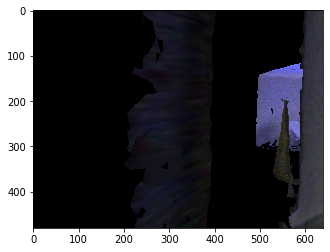

In [98]:

rtra = env._sim.sample_navigable_point()
ang = np.random.rand() * 2 * np.pi
rrot = quaternion.from_euler_angles(np.array([0, ang, 0]))

ang = np.random.rand() * 2 * np.pi
rrot = quaternion.from_euler_angles(np.array([0, ang, 0]))

CAMERA_HEIGHT = 0.88

def topdown_position(tra, height=2.5):
    return np.array([tra[0], tra[1] + height, tra[2] + CAMERA_HEIGHT])

def get_imgs(tra, rot, height=3.0):
    td_tra = topdown_position(tra, height)
    euler_angles = np.array([np.pi/2, np.pi/2, -np.pi/2 + ang])
    td_rot = quaternion.from_euler_angles(euler_angles)
    obs = env._sim.get_observations_at(position=tra, rotation=rot, keep_agent_at_new_pose=True)
    td_obs = env._sim.get_observations_at(position=td_tra, rotation=td_rot, keep_agent_at_new_pose=False)
    return obs['rgb'], obs['depth'], td_obs['semantic']

r1, depth1, s1 = get_imgs(rtra, rrot, 5)
plt.imshow(r1)
plt.show()

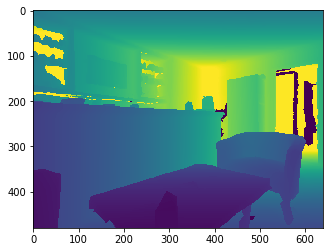

In [36]:
plt.imshow(d)

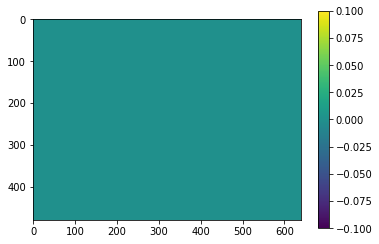

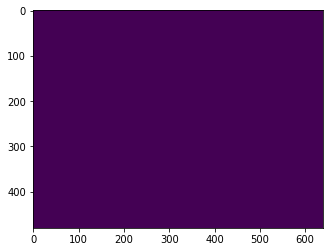

[[[-1.338091    1.62577446  0.92643303]
  [-1.33656163  1.62901492  0.92827957]]

 [[-1.34112538  1.62946122  0.92467305]
  [-1.33959663  1.632714    0.92651891]]]


In [59]:
HFOV = config.SIMULATOR.DEPTH_SENSOR.HFOV * np.pi / 180
VFOV = HFOV * 3 / 4

theta = np.zeros((480, 640))
phi = np.zeros((480, 640))

xyz = np.zeros((480, 640, 3))
for i in range(480):
    for j in range(640):
        x = (j - 320 + 0.5) / 320 * np.tan(HFOV / 2)
        z = (240 - i + 0.5) / 240 * np.tan(VFOV / 2)
        xyz[i, j] = np.array([x, 1, z]) * (depth[i, j, 0] / np.sqrt(x ** 2 + z ** 2 + 1))
#         if x < 0:
#             phi[i, j] = np.pi - np.arctan(-1 / x)
#         else:
#             phi[i, j] = np.arctan(1 / x)
#         if z < 0:
#             theta[i, j] = np.pi - np.arctan(-np.sqrt(x ** 2 + 1) / z)
#         else:
#             theta[i, j] = np.arctan(np.sqrt(x ** 2 + 1) / z)
#         phi[i, j ] = (320 - j + 0.5) / 320 * HFOV / 2 + np.pi / 2
#         theta[i, j ] = (i - 240 + 0.5) / 240 * VFOV / 2 + np.pi / 2
plt.imshow(phi)
plt.colorbar()
plt.show()
plt.imshow(theta)
plt.show()

d = depth[:, :, 0]

# xyz[:, :, 0] = d * np.sin(theta) * np.cos(phi)
# xyz[:, :, 1] = d * np.sin(theta) * np.sin(phi)
# xyz[:, :, 2] = d * np.cos(theta)
print(xyz[:2, :2])
sample_pc = xyz.reshape(480 * 640, 3)

In [60]:

import sys
import argparse
import importlib
import torch.optim as optim

BASE_DIR = os.getcwd()
ROOT_DIR = BASE_DIR
sys.path.append(os.path.join(ROOT_DIR, 'utils'))
sys.path.append(os.path.join(ROOT_DIR, 'models'))
from pc_util import random_sampling, read_ply
from ap_helper import parse_predictions

num_point = 20000

def preprocess_point_cloud(point_cloud):
    ''' Prepare the numpy point cloud (N,3) for forward pass '''
    point_cloud = point_cloud[:,0:3] # do not use color for now
    floor_height = np.percentile(point_cloud[:,2],0.99)
    height = point_cloud[:,2] - floor_height
    point_cloud = np.concatenate([point_cloud, np.expand_dims(height, 1)],1) # (N,4) or (N,7)
    point_cloud = random_sampling(point_cloud, num_point)
    pc = np.expand_dims(point_cloud.astype(np.float32), 0) # (1,40000,4)
    return pc

if __name__=='__main__':
    
    # Set file paths and dataset config
    demo_dir = os.path.join(BASE_DIR, 'demo_files') 
    sys.path.append(os.path.join(ROOT_DIR, 'sunrgbd'))
    from sunrgbd_detection_dataset import DC # dataset config
    checkpoint_path = os.path.join(demo_dir, 'pretrained_votenet_on_sunrgbd.tar')
    pc_path = os.path.join(demo_dir, 'input_pc_sunrgbd.ply')


    eval_config_dict = {'remove_empty_box': True, 'use_3d_nms': True, 'nms_iou': 0.25,
        'use_old_type_nms': False, 'cls_nms': False, 'per_class_proposal': False,
        'conf_thresh': 0.5, 'dataset_config': DC}

    # Init the model and optimzier
    MODEL = importlib.import_module('votenet') # import network module
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = MODEL.VoteNet(num_proposal=256, input_feature_dim=1, vote_factor=1,
        sampling='seed_fps', num_class=DC.num_class,
        num_heading_bin=DC.num_heading_bin,
        num_size_cluster=DC.num_size_cluster,
        mean_size_arr=DC.mean_size_arr).to(device)
    print('Constructed model.')
    
    # Load checkpoint
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    checkpoint = torch.load(checkpoint_path)
    net.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    print("Loaded checkpoint %s (epoch: %d)"%(checkpoint_path, epoch))
   
    # Load and preprocess input point cloud 
    net.eval() # set model to eval mode (for bn and dp)
    #point_cloud = read_ply(pc_path)
    point_cloud = sample_pc
    pc = preprocess_point_cloud(point_cloud)
    #print('Loaded point cloud data: %s'%(pc_path))
   
    # Model inference
    inputs = {'point_clouds': torch.from_numpy(pc).to(device)}
    tic = time.time()
    with torch.no_grad():
        end_points = net(inputs)
    toc = time.time()
    print('Inference time: %f'%(toc-tic))
    end_points['point_clouds'] = inputs['point_clouds']
    pred_map_cls = parse_predictions(end_points, eval_config_dict)
    print('Finished detection. %d object detected.'%(len(pred_map_cls[0])))
  
    dump_dir = os.path.join(demo_dir, '%s_results'%('habitat'))
    if not os.path.exists(dump_dir): os.mkdir(dump_dir) 
    MODEL.dump_results(end_points, dump_dir, DC, True)
    print('Dumped detection results to folder %s'%(dump_dir))


Constructed model.
Loaded checkpoint /home/azav/habitat-challenge/lsvm_objectnav/votenet/demo_files/pretrained_votenet_on_sunrgbd.tar (epoch: 180)
Inference time: 0.082164
Finished detection. 3 object detected.
Dumped detection results to folder /home/azav/habitat-challenge/lsvm_objectnav/votenet/demo_files/habitat_results
